In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures   
from sklearn.model_selection import KFold    
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

import numpy as np
import warnings

In [2]:
def standardize_features(X):
    X_standardized = X.copy()
    # Skip the first column (bias term)
    mean = X[:, 1:].mean(axis=0)
    std = X[:, 1:].std(axis=0)
    
    X_standardized[:, 1:] = (X[:, 1:] - mean) / std
    return X_standardized, mean, std

In [3]:
def polynomial_features(X, degree):
    X_poly = np.zeros((X.shape[0], degree + 1))
    for d in range(degree + 1):
        X_poly[:, d] = X[:, 0] ** d
    return X_poly
    

In [4]:
def train_linear_regression(X, y):
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    
    return w

In [6]:
def train_ridge_regression(X, y, lambda_value):
    I = np.identity(X.shape[1])
    w = np.linalg.inv(X.T @ X + lambda_value * I) @ X.T @ y
    
    return w    

In [5]:
def predict(X, w):
    return X @ w

In [7]:
def cross_validate(X, y, degrees, kf):
    
    avg_rmse = {}
    
    for degree in degrees:
        rmse_scores = []
        
        for i, (train_idx, val_idx) in enumerate(kf.split(X)):
            
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Polynomial Features
            X_train_poly = polynomial_features(X_train, degree)
            X_val_poly = polynomial_features(X_val, degree)
            
            # Standardize features
            X_train_scaled, mean, std = standardize_features(X_train_poly)
            X_val_scaled = X_val_poly.copy()
            X_val_scaled[:, 1:] = (X_val_poly[:, 1:] - mean) / std
            
            # Train model
            w = train_linear_regression(X_train_scaled, y_train)
                                
            # Predict on Validation set
            y_val_pred = predict(X_val_scaled, w)
            
            rmse = root_mean_squared_error(y_val, y_val_pred)
            rmse_scores.append(rmse)
        
        avg_rmse[degree] = np.mean(rmse_scores)
    
    return avg_rmse
    

In [16]:
def cross_validate_ridge(X, y, degree, kf, lambda_values, best_rmse=best_rmse, best_lambda=best_lambda):
    
    for lambda_value in lambda_values:
        
        cv_rmse = []
        
        for i, (train_idx, val_idx) in enumerate(kf.split(X)):
                
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # Polynomial Features
            X_train_poly = polynomial_features(X_train_fold, degree)
            X_val_poly = polynomial_features(X_val_fold, degree)
            
            # Standardize features
            X_train_scaled, mean, std = standardize_features(X_train_poly)
            X_val_scaled = X_val_poly.copy()
            X_val_scaled[:, 1:] = (X_val_poly[:, 1:] - mean) / std
            
            # Train model
            w_ridge = train_ridge_regression(X_train_scaled, y_train_fold, lambda_value)
                                
            # Predict on Validation set
            y_val_pred = predict(X_val_scaled, w_ridge)
            
            rmse = root_mean_squared_error(y_val_fold, y_val_pred)
            cv_rmse.append(rmse)
            
        avg_rmse = np.mean(cv_rmse)
        
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_lambda = lambda_value
            
    return best_rmse, best_lambda

In [23]:
def plot_points(X, y, degree):
    
    # Get polynomial features
    X_poly = polynomial_features(X, degree)
    
    # Standardize features
    X_poly_scaled, mean, std = standardize_features(X_poly)
    
    # Train model
    w = train_linear_regression(X_poly_scaled, y)
    
    # Smooth line for polynomial curve
    X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    X_plot_poly = polynomial_features(X_plot, degree)
    X_plot_poly[:, 1:] = (X_plot_poly[:, 1:] - mean) / std
    y_plot = (X_plot_poly @ w).flatten()
    
    plt.scatter(X[:, 0], y[:, 0], color="blue", label="Datapoints")
    plt.plot(X_plot, y_plot, color="red", label=f"Polynomial Regression for (degree={degree})")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Polynomial Regression Fit")
    plt.legend()
    plt.show()
        

In [10]:
# Generate degrees
degrees = [x for x in range(1, 28)]
# Generate Lambda values 
exponents = np.arange(-30, 12, 2)
lambda_values = np.exp(exponents)
lambda_values = np.insert(lambda_values, 0, 0)
# Store best values 
best_lambda = None
best_rmse = float("inf")
# Cross Fold Validation 12 folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)


In [11]:
df_train = pd.read_csv("./train.dat", delimiter=' ', header=None)
df_test = pd.read_csv("./test.dat", delimiter=' ', header=None)

In [12]:
X_train = df_train.iloc[:, 0].to_numpy().reshape(-1, 1)
X_test = df_test.iloc[:, 0].to_numpy().reshape(-1, 1)
y_train = df_train.iloc[:, 1].to_numpy().reshape(-1, 1)
y_test = df_test.iloc[:, 1].to_numpy().reshape(-1, 1)

In [13]:
cv_results = cross_validate(X_train, y_train, degrees=degrees, kf=kf)

In [37]:
best_degree = min(cv_results, key=cv_results.get)

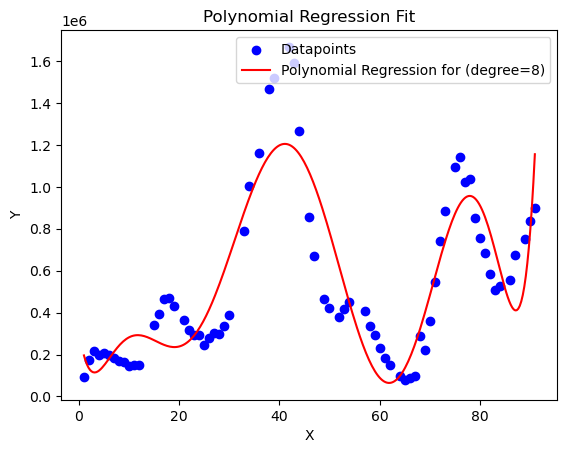

In [38]:
plot_points(X_train, y_train, degree=best_degree)

In [17]:
best_rmse, best_lambda = cross_validate_ridge(X_train, y_train, 28, kf, lambda_values)

In [18]:
print(f"Best RMSE: {best_rmse}, Best lambda: {best_lambda}")

Best RMSE: 256810.95166760669, Best lambda: 2.061153622438558e-09


In [ ]:
# Transform full training and test sets
X_train_poly = polynomial_features(X_train, best_degree)
X_test_poly = polynomial_features(X_test, best_degree)

# Standardize using training data mean/std
X_train_scaled, mean, std = standardize_features(X_train_poly)
X_test_scaled = X_test_poly.copy()
X_test_scaled[:, 1:] = (X_test_poly[:, 1:] - mean) / std

# Train final Linear Regression model
final_w = train_linear_regression(X_train_scaled, y_train)
# Predict on test set
y_test_pred = predict(X_test_scaled, final_w)

# Compute final test RMSE
final_test_rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Final Test RMSE: {final_test_rmse:.2f}")


Final Test RMSE: 200551.58


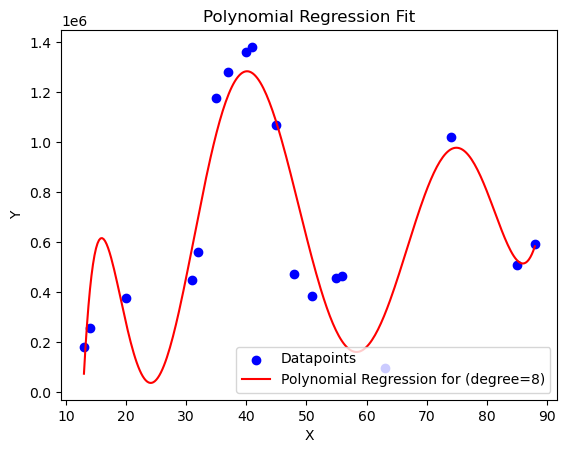

In [35]:
plot_points(X_test, y_test, best_degree)